# Neural Networks Experiments

## Students: <br>
Tomás Rojas <br>
Matías Montagna <br>
Alonso Utreras

## The objective of this notebook is to show the results from different models, including different inputs, but trying to get the same output.

In [1]:
import pandas as pd
import torch
import torch.optim as optim
from torch import nn
import numpy as np
from sklearn.model_selection import train_test_split
import log_info as log
from preprocessing import get_consecutive

# Get data
all_data = pd.read_csv(r".\data\cleaned-data\temuco_cleaned_data.csv")

all_data = all_data.dropna()

all_data["mp_25"] = all_data["mp_2,5"]
all_data = all_data.drop(["mp_2,5"], axis=1)


X = all_data[all_data.columns[2:-1]]
Y = all_data[all_data.columns[-1]]
# Y = all_data[all_data.columns[:-4]].join(Y) # para que tenga todo

In [2]:
X.head()

,direccion_viento,humedad_relativa,precipitaciones,presion_atmosferica,temperatura_ambiente,velocidad_viento
0,264.0,71.0,0.0,1001.0,11.9,1.4
1,263.0,74.0,0.0,1001.0,11.2,1.4
2,288.0,77.0,0.0,1000.0,10.6,1.0
3,273.0,81.0,0.0,1000.0,10.1,1.2
4,263.0,83.0,0.0,1001.0,10.0,1.2


In [3]:
Y.head()

0     8.20000
1     6.89999
2     6.60000
3     8.79999
4    13.90000
Name: mp_25, dtype: float64

### Dividing data into train, test and validation sets
We chose a train size of 70% of all data, while 15% corresponds to test and 15% to validation data.

In [4]:
test_data_size = int(len(all_data) * 0.7)

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

_X_train, _X_test, _y_train, _y_val = train_test_split(X, Y, test_size=0.3, random_state=42)


### Setting device to work with. Use cuda if available.

In [5]:
device = ('cpu' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Classes for training our models:

## First model, which is a simple ff NN using just date.
Simple feedforward NN
Input: Date

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class LSTMModel(nn.Module):
    """LSTM layer + linear to get output"""

    def __init__(self, input_size, n_hidden=128, n_layers=3,  output_size=1, model_name="LSTM", batch_size=1, dropout=0.2):
        super().__init__()
        
        self.input_size = input_size
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.batch_size = batch_size

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=n_hidden,
            num_layers=n_layers,
            dropout=dropout
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=output_size)
        self.name = model_name
        # error with double type

        #h_0 of shape (num_layers * num_directions, batch, hidden_size)
        #c_0 of shape (num_layers * num_directions, batch, hidden_size): tensor containing the initial cell state for each element in the batch.

    def reset_hidden_state(self):
        """Initialize hidden state"""
        self.hidden = (
            torch.zeros(self.n_layers, self.batch_size, self.n_hidden).to(device),
            torch.zeros(self.n_layers, self.batch_size, self.n_hidden).to(device)
            )

    def forward(self, _input):
        if len(_input.size()) == 3:
            seq_len = _input.size()[1]

        if len(_input.size()) == 2:
            seq_len = _input.size()[0]

        _input = _input.view(seq_len, self.batch_size , self.input_size).float()

        lstm_out, self.hidden = self.lstm(_input, self.hidden)
        lstm_out = lstm_out.float()

        y_pred = self.linear(lstm_out.view(seq_len, -1)).float()
  
        return y_pred

# Setting model to use and its name
model_name = "Temp PM LSTM 3 layers. 128 hidden size"
model_1_temp_pm = LSTMModel(6, 128, 3, 1, "Temp PM LSTM 3 layers. 128 hidden size")
loss_1 = nn.MSELoss()

# Setting model, loss and optimizer
model = model_1_temp_pm.to(device)
loss = loss_1.to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters())

# Setting logger
Logger = log.LogInfo(
    model=model, 
    logging_name=model_name
    )
Logger.add_info("Model using LSTM. hidden dim = 128.\n Having 3 layers.\n Data normalized")

# Hyperparamters
n_epochs = 5

## Training function

In [7]:
import time

def init_weights(model):
    # Inicializamos los pesos como aleatorios
    for name, param in model.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.1) 

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# TODO: Completar
def batcher(training_data, batch_size=365*24):
    """TODO: FIX for our data. We still don't know  how our data is going to be.  """
    inout_seq = []
    L = len(training_data)
    for i in range(L-batch_size):
        train_seq = input_data[i:i+batch_size]
        train_label = input_data[i+batch_size:i+batch_size+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq


def train(model, x_train, y_train, optimizer, loss_function, epochs=5, batch_size=365*24):
    model.train()
    total_loss = 0

    for i in range(epochs):
        # each epoch
        epoch_loss = 0
        best_test_loss = float('inf')
        # /_input.size()[1], 1 , self.input_size)
        # x_i => (1 , self.input_size)
        # x_i.size[1]
        for x_i, y_i in zip(x_train, y_train):

            # Each batch
            # initialize the hidden state.
            model.reset_hidden_state()

            x_i = x_i.to(device)
            y_i = y_i.to(device).float()
            optimizer.zero_grad()
            y_pred = model(x_i).float()

            loss = loss_function(y_pred, y_i).float()
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

        # Save results from the best trained model
        if epoch_loss < best_test_loss:
            best_test_loss = epoch_loss
            torch.save(model.state_dict(), '{}.pt'.format(model.name))
            
        total_loss += epoch_loss
        print(f'epoch: {i} loss: {epoch_loss:10.8f}')

    print(f'Average loss: {total_loss/len(x_train):4f}')
    return total_loss

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def test(model, x_test, y_test, loss_function, batch_size=365*24):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for x_i, y_i in zip(x_test, y_test):
            # predict data using the given model
            model.reset_hidden_state()

            prediction = model(x_i)
            # Compute loss
            total_loss += loss_function(prediction, y_i).float().item()

    print(total_loss)
    return total_loss

def load_best_model(model):
    return model.load_state_dict(torch.load(f'{model.name}.pt'))

### Execute Training and Testing:

In [8]:
# Execute training
def execute_training(model, x_train, y_train, x_test, y_test, optimizer, loss_function, logger, n_epochs=5, batch_size=365*24):
    # Train

    start_time = time.time()
    train_loss = train(model, x_train, y_train, optimizer, loss_function, n_epochs, batch_size)
    end_time = time.time();
    train_time = end_time - start_time

    print(f'Training time = {train_time}')
    print(f'Train Loss: {train_loss}')


    # Test
    start_time = time.time()

    test_loss = test(model, x_test, y_test, loss_function, batch_size)
    end_time = time.time()
    test_time = end_time - start_time 

    print(f'\t Val. Loss: {test_loss:.3f}')

    logger.model_loss['train'] = train_loss
    logger.model_loss['test'] = test_loss
    logger.set_train_test_size(x_train, x_test)
    logger.set_training_time(train_time)
    # logger.set_epochs(n_epochs)
    # logger.set_optimizer(optimizer)



In [9]:
# Clean CUDA RAM
torch.cuda.empty_cache()

## Train and Test model 

### Normalizing train data:
We read here https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/
that it is important to normalize data when working with time series. 


In [10]:
from sklearn.preprocessing import MinMaxScaler

x_train_np = np.asarray(_X_train.values)
y_train_np = np.asarray(_y_train.values)

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_normalized = scaler.fit_transform(x_train_np)
y_train_normalized = scaler.fit_transform(y_train_np.reshape(-1, 1))

X_train = torch.from_numpy(X_train_normalized)
y_train = torch.from_numpy(y_train_normalized)

# Transforming data into tensors
X_tensor = X_train.view(X_train.size()[0], 1, X_train.size()[1])
X_tensor = X_tensor.transpose(0, 1)

# train_data_normalized = torch.FloatTensor(X_train).view(-1)

In [11]:
X_train.size()

torch.Size([99857, 6])

### Transforming data Shape to work well with batches and our models.

In [12]:
# X_train = X_train.transpose(0, 1)
# y_train = y_train.transpose(0, 1)
y_tensor = y_train.view(1, -1)
# X_tensor = X_tensor.transpose(0, 1)
# y_tensor = y_tensor.transpose(0, 1)

In [13]:
y_tensor.size()

torch.Size([1, 99857])

In [14]:
X_train = X_tensor[:,0:1000,:].to(device)
y_train = y_tensor[:, 0:1000].to(device)
X_test = X_tensor[:,1000:1100, :].to(device)
y_test = y_tensor[:, 1000:1100].to(device)

In [15]:
y_train.size()

torch.Size([1, 1000])

In [16]:
print(f'The current model contains {count_parameters(model)} trainable parameters.')     
model = model.float()
model.apply(init_weights)


execute_training(
    model=model,
    x_train=X_train,
    y_train=y_train,
    x_test=X_test,
    y_test=y_test,
    optimizer=optimizer,
    loss_function=loss,
    logger=Logger,
    n_epochs=n_epochs
    )

The current model contains 333953 trainable parameters.
epoch: 0 loss: 0.43127957
epoch: 1 loss: 0.09363735
epoch: 2 loss: 0.01087188
epoch: 3 loss: 0.08554647
epoch: 4 loss: 0.07142472
Average loss: 0.692760
Training time = 10.559594631195068
Train Loss: 0.6927599813789129
0.04537283256649971
	 Val. Loss: 0.045


In [17]:
load_best_model(model)

# Export info to a logger to store results
Logger.export_info()

### Plotting predicted data vs real data using testing set

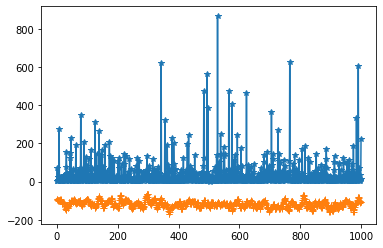

In [18]:
import matplotlib.pyplot as plt

y_pred = model(X_train)

X_train_np = X_train.cpu().detach().numpy()
y_train_np = y_train.cpu().detach().numpy().reshape(-1)

y_pred_plot = y_pred.cpu().detach().numpy().reshape(-1)

actual_values = \
    scaler.inverse_transform(y_train_np.reshape(-1, 1))

actual_predictions = \
    scaler.inverse_transform(y_pred_plot.reshape(-1, 1))

# actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))

fig, ax = plt.subplots()

plt.plot(actual_values, marker="*", label="results")
plt.plot(actual_predictions, marker="+", label="predictions")

plt.show()



In [19]:
import matplotlib.pyplot as plt


# Transform tensors to numpy arrays
y_pred = model(X_test)
X_test_np = X_test.cpu().detach().numpy()
y_test_np = y_test.cpu().detach().numpy()
y_pred_np = y_pred.cpu().detach().numpy()


fig, ax = plt.subplots()

# plot both real values and prediction values
results_plot = plt.scatter(X_test_np, y_test_np, marker="*", label="results")
pred_plot = plt.scatter(X_test_np, y_pred_np, marker="+", label="predictions")

ax.legend()            
plt.xlabel("temperature")
plt.ylabel("mp2.5")
plt.title(model.name)

# plot results and store it in results directory
plt.show()
plt.savefig(f'./results/{model.name}')

ValueError: x and y must be the same size